<a href="https://colab.research.google.com/github/MoranReznik/MusicGenerator/blob/main/MusicGenWithEmbbedings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install requeird libreries
!pip install mido

# imports
import os
from scipy.special import softmax
import torch
import mido
import numpy as np
import math
import torch.nn as nn
import torch.utils.data as data
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import matplotlib.pyplot as plt
from utils import *
import math
import torch.nn.functional as F

# needed only for MAC
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# creating cude device to run on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device))
if str(device) == 'cuda':
  print(torch.cuda.get_device_name())

     |████████████████████████████████| 51kB 4.3MB/s 
device: cuda
Tesla P100-PCIE-16GB


In [2]:
# unzipping the file with the music pieces
!unzip /content/MusicMatrices1.zip

Archive:  /content/MusicMatrices1.zip
   creating: MusicMatrices/
  inflating: MusicMatrices/bach_850.mid.npy  
  inflating: MusicMatrices/mz_331_3.mid.npy  
  inflating: MusicMatrices/DEB_PASS.MID.npy  
  inflating: MusicMatrices/haydn_8_2.mid.npy  
  inflating: MusicMatrices/chpn-p6.mid.npy  
  inflating: MusicMatrices/chpn-p10.mid.npy  
  inflating: MusicMatrices/schu_143_3.mid.npy  
  inflating: MusicMatrices/schubert_D935_1.mid.npy  
  inflating: MusicMatrices/chpn_op27_1.mid.npy  
  inflating: MusicMatrices/chpn_op23.mid.npy  
  inflating: MusicMatrices/ty_januar.mid.npy  
  inflating: MusicMatrices/mendel_op30_5.mid.npy  
  inflating: MusicMatrices/scn15_12.mid.npy  
  inflating: MusicMatrices/pathetique_2.mid.npy  
  inflating: MusicMatrices/gra_esp_4.mid.npy  
  inflating: MusicMatrices/brahms_opus117_1.mid.npy  
  inflating: MusicMatrices/debussy_cc_6.mid.npy  
  inflating: MusicMatrices/schum_abegg.mid.npy  
  inflating: MusicMatrices/muss_8.mid.npy  
  inflating: MusicMatri

In [6]:
# creating the vocabulary
vocab = []
path = '/content/MusicMatrices'
pieces = {}
for i in os.listdir(path):
  if '.npy' in i:
    mat = np.load(path+'/'+i)
    pieces[i] = mat
    l = mat.tolist()
    for j in l:
      # convert to array, remove length (was in position 89 at each vector)
      # and set all note velocity to same value
      j = np.array(j)
      j[0:88][j[0:88] > 0] = 50
      j = j[0:88]
      j = list(j)

      vocab.append(str(j))
vocab = list(set(vocab))
print('number of unique combination of notes ("words"): '+str(len(vocab)))

number of unique combination of notes ("words"): 59392


In [5]:
# transition dicts from word to vec and back dicts
w2i = {}
i2w = {}
for i, word in enumerate(vocab):
  w2i[word] = i
  i2w[i] = word

In [14]:
class Dataset(torch.utils.data.Dataset):
  """create a torch dataset to load the data into the model during training"""

  def __init__(self, seq_len, n_pieces=250):
    """initiate the dataset"""

    # initate class variables
    self.seq_len = seq_len # length of dequence fed into the model
    self.lengths = {} # number of training examples in each music piece
    self.examlpe_num = 0 # number of total trainig examples in dataset

    # calulate values for self.lengths and self.examlpe_num
    for piece_name in os.listdir('/content/MusicMatrices/')[:n_pieces]:
      if 'npy' in piece_name:
        piece = pieces[piece_name]
        self.lengths[piece_name] = piece.shape[0] - (self.seq_len+1)
        self.examlpe_num += piece.shape[0] - (self.seq_len+1)

  def __len__(self):
        'Denotes the total number of samples'
        return self.examlpe_num

  def __getitem__(self, example_idx):
        """retirives a training example given idx"""
        
        # deduce the piece that contains the index by iterating over their number of training examples
        s = 0
        for piece_check in self.lengths:
          if s + self.lengths[piece_check] > example_idx:
            piece = piece_check
            example_idx -= s
            break
          s += self.lengths[piece_check]

        # load the piece and exctract training example
        piece = pieces[piece]
        x = piece[example_idx:example_idx+self.seq_len,:]
        y = piece[example_idx+1:example_idx+self.seq_len+1,:]

        # convert to array, remove length (was in position 89 at each vector)
        # and set all note velocity to same value
        x[:,0:88][x[:,0:88] > 0] = 50
        y[:,0:88][y[:,0:88] > 0] = 50
        x = x[:,0:88]
        y = y[:,0:88]

        # convert the a list of the words' indexes 
        x = [str(j) for j in x.tolist()]
        y = [str(j) for j in y.tolist()]
        x = [w2i[j] for j in x]
        y = [w2i[j] for j in y]

        # convert to tensors, and create one hot encoding to the target words
        x = torch.tensor(x).long()
        y = torch.tensor(y).long()
        y = nn.functional.one_hot(y, num_classes=len(vocab))
        
        return x, y

In [15]:
class AttentionError(Exception):
    pass

class MultiheadedAttention(nn.Module):
    """
    Narrow multiheaded attention. Each attention head inspects a 
    fraction of the embedding space and expresses attention vectors for each sequence position as a weighted average of all (earlier) positions.
    """

    def __init__(self, d_model, sequence_len, heads=8, dropout=0.1):
        """initiate the layer"""
        super().__init__()

        # make sure embedding size is devidable by number of heads
        if d_model % heads != 0:
            raise AttentionError("Number of heads does not divide model dimension")

        # initate class variables
        self.d_model = d_model # embedding size
        self.heads = heads # number of heads
        s = d_model // heads # features per head
        self.linears = []
        for head in range(heads):
          self.linears.append(torch.nn.ModuleList([nn.Linear(s, s, bias=False) for i in range(3)])) # linear layers: WQ, WK and WV
        self.recombine_heads = nn.Linear(heads * s, d_model) # combines heads back to single output of the right size
        self.dropout = nn.Dropout(p=dropout) # dropout layer
        self.Er = torch.randn([s, sequence_len], device=device, requires_grad=True) # relative positinal embedding matrix

    def forward(self, x):
        x_mask = (x != 0)
        mask = x_mask.type(torch.uint8)
        x = x.permute(1,0,2)
        #batch size, sequence length, embedding dimension
        b, t, e = x.size()
        #each head inspects a fraction of the embedded space
        h = self.heads
        #single head dimension
        s = e // h
        # devide input to seperate dim for each head 
        x = x.view(b,t,h,s)
        # compute seperate queries, keys and values for each head
        queries, keys, values = [], [], []
        for head in range(self.heads):
          x_head = x[:,:,head,:]
          q, k, v = [w(x) for w, x in zip(self.linears[head].to(device), (x_head,x_head,x_head))]
          queries.append(q)
          keys.append(k)
          values.append(v)

        #apply same position embeddings across the batch
        SRel = []
        for head in range(self.heads):
          QEr = torch.matmul(queries[head], self.Er)
          SRel.append(QEr.contiguous().view(b, t, t))
 
        #Compute scaled dot-product self-attention   
        head_represenations = []
        for head in range(self.heads):
          # scale pre-matrix multiplication for stability
          queries[head] = queries[head] / (e ** (1/4))
          keys[head] = keys[head] / (e ** (1/4))
          # multiply queries by keys
          scores_head = torch.bmm(queries[head], keys[head].transpose(1, 2))
          # add atantion socres to relative positional scores
          scores = scores_head + SRel[head]   
          # mask 
          subsequent_mask = torch.triu(torch.ones(1, t, t, device=device), 1)
          scores = scores.masked_fill(subsequent_mask == 1, -1e9)
          #Convert scores to probabilities
          attn_probs = F.softmax(scores, dim=2)
          attn_probs = self.dropout(attn_probs)
          #use attention to get a weighted average of values
          head_represenations.append(torch.bmm(attn_probs, values[head]).view(b, t, s))
        
        out = torch.cat(head_represenations, dim=2)
        #transpose and recombine attention heads
        out = out.transpose(1, 2).contiguous().view(b, t, s * h)
        #last linear layer of weights
        return self.recombine_heads(out)

class Transformer(nn.Module):
  def __init__(self, seq_len, num_token, num_inputs, num_heads, num_layers, dropout=0.3):
      """initiate the model"""
      super(Transformer, self).__init__()
      self.num_layers = num_layers
      self.enc = nn.Embedding(num_token, num_inputs-3)
      self.bns = torch.nn.ModuleList([nn.BatchNorm1d(seq_len) for i in range(num_layers)])
      self.enc_transformer = torch.nn.ModuleList([MultiheadedAttention(num_inputs, seq_len,heads=num_heads, dropout=dropout) for i in range(num_layers)])
      self.num_inputs = num_inputs
      self.dec = nn.Linear(num_inputs, num_token)
      pos_embeds = torch.randn((seq_len,1,3), device=device,requires_grad=True)
      self.pos_embeds = pos_embeds.repeat(1,batch_size,1) # repeat to fit batch dimention

  def forward(self, source):
      # word embedding layer, scaled for numerical stability
      source = self.enc(source) * math.sqrt(self.num_inputs)
      # adding positnial embeddings
      source = torch.cat([source, self.pos_embeds], axis=2)
      # layers of multy head self attantion and batch-norm
      for layer in range(self.num_layers):
          source = source.swapaxes(0,1)
          source = self.bns[layer](source)
          source = source.swapaxes(0,1)
          source = self.enc_transformer[layer](source)
          source = source.swapaxes(0,1)
      # decoder
      op = self.dec(source)
      return op

In [33]:
# setting veriables, building model
seq_len = 50
batch_size=32
n_heads = 8
emb_head = 30
n_layers = 3
m = Transformer(seq_len,len(w2i), emb_head*n_heads, n_heads, n_layers, dropout=0.0).to(device)
loss_func = nn.BCEWithLogitsLoss() 
opt = torch.optim.Adam(m.parameters(), lr=0.01)

In [34]:
# data dict
path = '/content/MusicMatrices'
# lists for tracking performance
all_losses = []
all_accs = []
# load model
#m.load_state_dict(torch.load('/content/model.pt'))
# set to training mode
m.train()
# training loop
for epoch in range(10):
  # print epoch num
  print('epoch: ' + str(epoch))
  # lists for tracking performance (within epoch)
  losses = []
  accs = []
  # build dataset and dataloader
  dataset = Dataset(seq_len, 2900)
  generator = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
  # initiate counter for batches trained on
  counter = 0
  for x, y in generator:
    counter += 1
    # get data ready
    x, y = x.to(device), y.float().to(device)
    opt.zero_grad()
    x = x.swapaxes(1,0)
    y = y.swapaxes(1,0)
    # run model
    output = m(x)
    # sample accuracy
    if counter % 5 == 0:
        accs.append(torch.sum(torch.argmax(y, axis = 2) == torch.argmax(output, axis = 2)) / (output.shape[0] * output.shape[1]))
    # calculate loss and update model
    loss = loss_func(output, y)
    losses.append(loss.item())
    loss.backward()
    opt.step()
    # save perfurmance
    if counter % 100 == 0:
        print(f'[{counter}/{len(generator)}]')
        print(round(np.mean(losses)*10000, 2), round(np.mean([x.cpu().detach().numpy() for x in accs]), 2))
        all_accs.append(round(np.mean([x.cpu().detach().numpy() for x in accs]), 2))
        all_losses.append(round(np.mean(losses)*10000, 2))
        losses = []
        accs = []
        print()
# plot performance
f, a = plt.subplots(2,1,figsize=(18,10))
a[0].plot(all_losses)
a[1].plot(all_accs)

epoch: 0
[100/14501]
261.76 0.05

[200/14501]
8.42 0.08

[300/14501]
7.3 0.08

[400/14501]
5.87 0.07

[500/14501]
4.61 0.06

[600/14501]
3.79 0.08

[700/14501]
3.51 0.08

[800/14501]
3.05 0.07

[900/14501]
2.71 0.07

[1000/14501]
2.61 0.08

[1100/14501]
2.35 0.08

[1200/14501]
2.23 0.08

[1300/14501]
2.11 0.08

[1400/14501]
2.15 0.08

[1500/14501]
2.04 0.08

[1600/14501]
1.96 0.09

[1700/14501]
1.91 0.08

[1800/14501]
1.94 0.08

[1900/14501]
1.88 0.07

[2000/14501]
1.85 0.08

[2100/14501]
1.81 0.08

[2200/14501]
1.79 0.08

[2300/14501]
1.78 0.08

[2400/14501]
1.77 0.08

[2500/14501]
1.78 0.09

[2600/14501]
1.76 0.08

[2700/14501]
1.77 0.08

[2800/14501]
1.75 0.07

[2900/14501]
1.75 0.08

[3000/14501]
1.74 0.08

[3100/14501]
1.74 0.08

[3200/14501]
1.73 0.08

[3300/14501]
1.72 0.09

[3400/14501]
1.73 0.09

[3500/14501]
1.72 0.08

[3600/14501]
1.71 0.08

[3700/14501]
1.71 0.08

[3800/14501]
1.71 0.08

[3900/14501]
1.72 0.07

[4000/14501]
1.69 0.09

[4100/14501]
1.7 0.08

[4200/14501]
1.7

KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.


(235, 88)


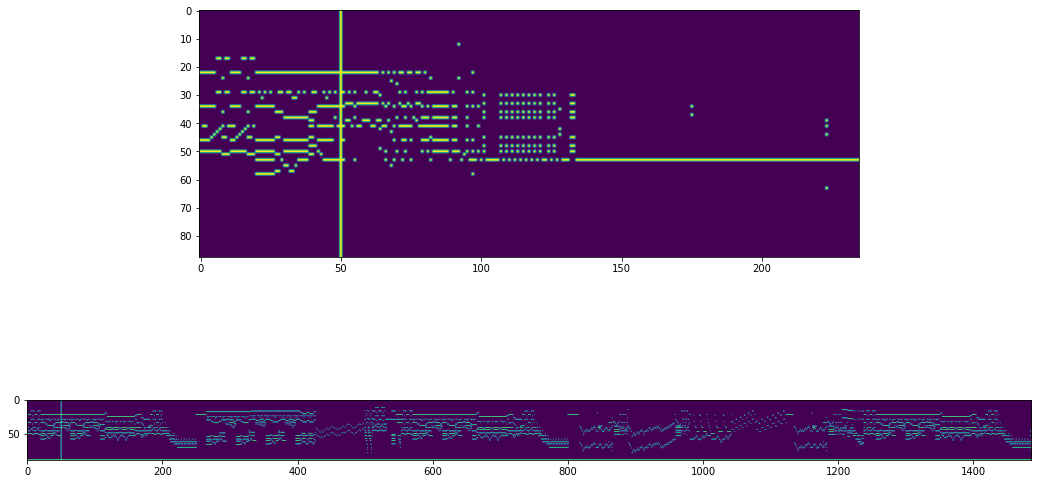

In [49]:
# prepare musical prompt
mat = np.load('/content/MusicMatrices/alb_se3.mid.npy')
gen = mat[0:seq_len,:]
gen = gen[:,0:88]
l = list(range(len(w2i)))
# length of genreated piece
ln = int(mat.shape[0] / 8)
# convert model to evaluation mode
m.eval()
# set temprature
temp = 1.3
# generate
with torch.no_grad():
    for i in range(ln):
        # prepare data
        start = gen[-seq_len:,:]
        start[:,0:88][start[:,0:88] > 0] = 50
        start = [str(j) for j in start.tolist()]
        start = [w2i[j] for j in start]
        start = torch.tensor(start).long().to(device).unsqueeze(0)
        start = start.repeat(32,1)
        start = start.swapaxes(0,1)
        # run model
        op = m(start)
        # convert to probablities
        pred = op[-1,0,:]
        pred = pred.cpu().detach().numpy()
        pred = pred*temp
        pred = softmax(pred)
        # do not choose option that are completly bizzare
        # pred[pred<0.004] = 0 
        # pred /= np.sum(pred)
        # choose next words
        pred = np.random.choice(l,p=pred)
        # add new word to piece
        pred = i2w[pred].replace('[','').replace('[','')
        pred = np.fromstring(pred, sep=', ').astype(int)
        pred = np.expand_dims(pred, 0)
        gen = np.concatenate([gen, pred])

# plot generated piece
f, a = plt.subplots(2,1,figsize=(18,10))
mat[mat > 1] = 1
gen_b = gen.copy()
gen_b[gen_b > 0] = 1
gen_b[seq_len,:] = 1
mat[seq_len,:] = 1
print(gen.shape)
a[0].imshow(gen_b.T)
a[1].imshow(mat.T)

In [ ]:
# convert to MIDI and save
a = np.expand_dims(np.array([100]*gen.shape[0]),1)
t = np.concatenate([gen, a], axis=1)
mat_decomp = decompress_mat(t)
arry2mid(mat_decomp, '/content/gen.mid',tempo=1503721)